# Machine Learning and Quantum Alchemy

---

# Class 1

In [1]:
# Commom imports
import matplotlib.pyplot as plt
import numpy as np
import math

1. Write a function which calculates the Morse potential of two atoms: morse_potential(distance: float) -> float. This is the target function which we will model. We assume all parameters to be unity for simplicity.

2. Plot the function and identify the domain of interest.

3. Write a function to generate n uniformly random data points (positions and their functional values) within that domain: generate_dataset(n: int) -> tuple[np.ndarray, np.ndarray]. We will use this for the training data and for the test data.

4. Implement nearest neighbor prediction at position by hand (without scikit-learn): predict_nearest_neighbor(position: float, training_xs: np.ndarray, training_ys: np.ndarray) -> float. Plot the results together with the correct function.

5. Do the same using scikit-learn (will be first introduced in class).

6. Play with the number of training data points and the parameters of k-nearest neighbors in the scikit-learn implementation. Focus on the low-data regime with about 5-10 points. What do you observe empirically?

* How can we choose which parameter is best? How should we choose which parameter is best?
* How does the fit quality improve with more data?
* Which regions are particularly hard to predict and why?
* Based on your findings for this 1D problem, which conclusions do you draw for higher dimensions?

7. What is the best 1-nearest neighbor (k=1) model you can build with three training points only? Use your intuition from the previous tasks to first predict the solution, then implement it numerically with either a grid search or with scipy.optimize.

In [2]:
# TASK 1
"""
Calculates the Morse potential of two atoms
"""
def morse_potential(distance: float) -> float:
  # https://en.wikipedia.org/wiki/Morse_potential
  de = 1;
  a = 1;
  re = 1;

  return de * ((1 - math.e**(-a*(distance - re))))**2;

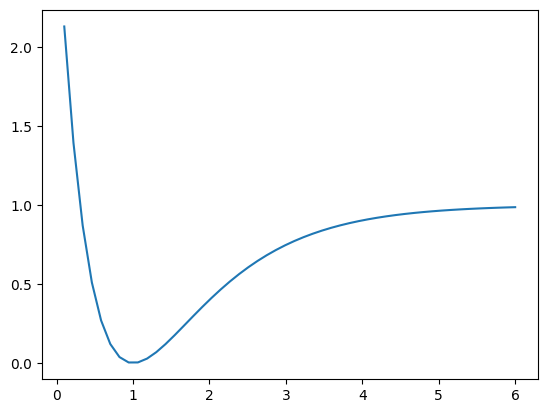

In [ ]:
# TASK 2
xs = np.linspace(0.1, 6);
ys = [morse_potential(_) for _ in xs]; # list comprehension

plt.plot(xs, ys);

In [3]:
# TASK 3
"""
Generates some points over the morse potential function
"""
def generate_dataset(n: int) -> tuple:
  xs = np.random.uniform(0.1, 6, n);

  # Python can understand xs (an object), and calculate the morse_potential,
  # even if the function expects a single parameter
  ys = morse_potential(xs);

  return xs, ys;

In [4]:
# TASK 4
"""
Calculates which training y point is closest to the given position
"""
def predict_nearest_neighbor(position: float, training_xs: np.ndarray, training_ys: np.ndarray) -> float:
  # Pyhton allows making calculations with a value and a vector:
  distances = abs(position - training_xs);

  # np.argmin gets the minimal value of the values passed
  nearest_neigbor_index = np.argmin(distances);

  # Notice that this algorithm is not very efficient, since it needs to calculate
  # the distance of each value in training_xs

  return training_ys[nearest_neigbor_index];

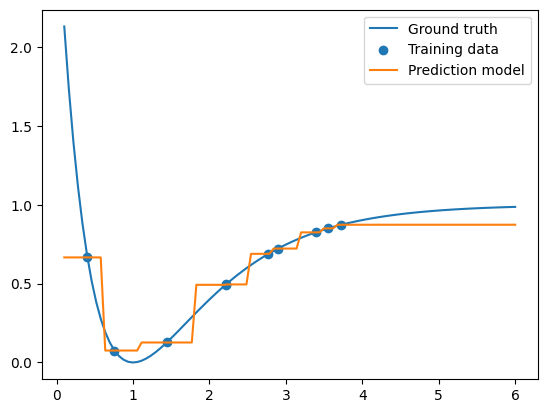

In [ ]:
# Training points
# (notice what happens making n bigger)
n = 10
training_xs, training_ys = generate_dataset(n);

# Ground truth
xs = np.linspace(0.1, 6, 100);
ys = morse_potential(xs);

# Plotting ground truth
plt.plot(xs, ys, label="Ground truth");

# Ploting training data
plt.scatter(training_xs, training_ys, label="Training data");

# Plotting prediction model
plt.plot(xs,
         [predict_nearest_neighbor(x, training_xs, training_ys) for x in xs],
         label="Prediction model");

plt.legend();

[1 2 3]
[1 2 3]
[[1]
 [2]
 [3]]


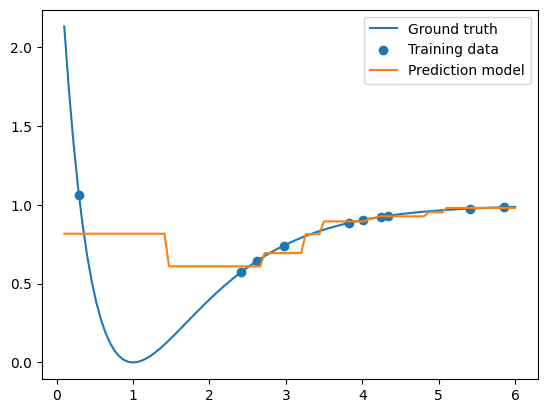

In [ ]:
# TASK 5
from sklearn import neighbors

''' Pseudo code:
# cls stands for "class"
cls = SomeModelRegressor()

# "Fit" function trains your model
X = training_data_matrix
y = training_data_labels
cls.fit(X, y)

# Inference
Xprime = query_feature_matrix
yprime = cls.predict(Xprime)
'''

# As before
training_xs, training_ys = generate_dataset(n);
xs = np.linspace(0.1, 6, 100);
ys = morse_potential(xs);

# SKLearn
cls = neighbors.KNeighborsRegressor(n_neighbors=2);
# Renaming training points; notice that X must be a 2D array
# so we use that trick to create a new axis [*]
X = training_xs[:, None];       # the same as train_xs[:, np.newaxis]
y = training_ys;

# Train the model
cls.fit(X, y);

# Inference
Xprime = xs[:, None];           # the same case as before
yprime = cls.predict(Xprime);

# Plot ground truth and training points
plt.plot(xs, ys, label="Ground truth");
plt.scatter(training_xs, training_ys, label="Training data");

# Plot prediction model
plt.plot(xs,
         yprime,
         label="Prediction model");

plt.legend();

####################################################################
# [*] Notice the following
a = np.array([1,2,3])
# Prints a
print(a);
# Prints a in the same way
print(a[:]);
# Two dimensional array
print(a[:, None]);


# Class 2

Instructions here: https://nablachem.org/lectures/mlqa24/day2/

In [5]:
# TASK 1
# Important: x1 and x2 are vectors!
"""
Generates a gaussian curve
"""
def gaussian_kernel(x1: np.ndarray, x2: np.ndarray, gamma=1) -> float:
  return math.e ** (-gamma * (np.linalg.norm(x1 - x2))**2);

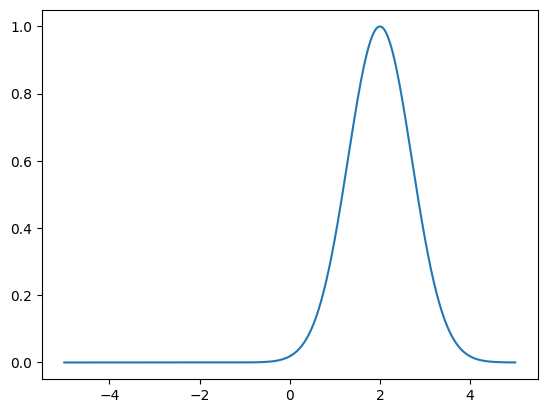

In [ ]:
xs = np.linspace(-5,5, 500);
ys = [gaussian_kernel(2, x) for x in xs];

plt.plot(xs, ys);

In [6]:
# TASK 2
def fit_krr(training_xs: np.ndarray, training_ys: np.ndarray, lbd=1e-10) -> np.ndarray:
  # Notice that we have a simetric matrix, with diagonal equals to 1,
  # so the loop can be optimized:
  n = len(training_ys);
  K = np.ones((n, n));

  for i in range(1,n):
    for j in range (i+1, n):
       K[i,j] = gaussian_kernel(training_xs[i], training_xs[j]);
       K[j,i] = K[i,j];

  I = np.identity(n)

  # Have in mind that calculating the inverse of the matrix costs a lot
  alpha = np.linalg.inv(K - lbd*I)@training_ys

  return alpha;

In [7]:
# TASK 3
def predict_krr(training_xs: np.ndarray, xprime: np.ndarray, alphas: np.ndarray) -> float:
  n = len(alphas);
  yprime = 0;

  for i in range (0, n):
    yprime += alphas[i] * gaussian_kernel(training_xs[i], xprime);

  return yprime;

In [8]:
# TASK 4
# This code was given
def get_geometry():
  import requests
  res = requests.get("https://zenodo.org/records/3994178/files/inp.xyz?download=1")
  geos = res.content.decode("utf-8").replace("C", "").replace("H", "")
  geos = geos.split("\n", maxsplit=2)[-1].replace("\n", " ")
  return np.array([float(_) for _ in geos.split()]).reshape(-1, 3)

def coulomb_matrix(positions: np.ndarray, nuclear_charges: np.ndarray) -> np.ndarray:
  n = len(nuclear_charges);

  M = np.zeros((n,n));

  for i in range(0, n):
    for j in range(0, n):
      if (i == j):
        M[i,j] = 0.5 * nuclear_charges[i]**(2.4)
      else:
        distance = np.linalg.norm(positions[i] - positions[j]);
        M[i,j] = (nuclear_charges[i] * nuclear_charges[j]) / distance;


  return M.reshape(-1);

In [9]:
# TASK 5
# This code was given
def get_data():
    import requests
    res = requests.get("https://zenodo.org/records/3994178/files/PBE.txt?download=1")
    charges = []
    energies = []
    for line in res.content.decode("ascii").split("\n")[1:-1]:
        c, e = line.split()
        charges.append([int(_) for _ in c])
        energies.append(float(e))
    charges, energies = np.array(charges, dtype=float), np.array(energies)
    ordering = np.arange(energies.shape[0])
    np.random.shuffle(ordering)
    return charges[ordering, :], energies[ordering]

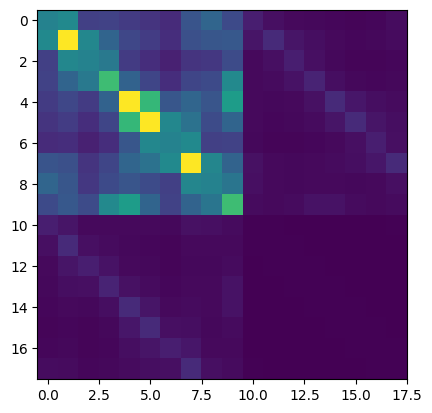

In [ ]:
geo = get_geometry();
dat = get_data();
charges = dat[0];

# The argmuent charges passed
cm = coulomb_matrix(geo, [6.]*10 + [1.]*8);

cm = coulomb_matrix(geo, list(charges[0]) + [1.]*8).reshape(18, 18);

plt.imshow(cm)

In [ ]:
charges, energies = get_data()
representations = []
for i in range(100):
    Zs = list(charges[i]) + [1.]*8
    representations.append(coulomb_matrix(geo, Zs))
alphas = fit_krr(representations, energies[:100])
errors = []
for i in range(len(energies)):
    Zs = list(charges[i]) + [1.]*8
    rep = coulomb_matrix(geo, Zs)
    errors.append(predict_krr(representations, rep, alphas) - energies[i])

# Class 3

In [10]:
!pip install pyscf
import pyscf.scf
import pyscf.gto

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 MB 17.5 MB/s eta 0:00:00


In [16]:
# TASK 1
"""
In chemistry, dimerization is the process of joining two identical or similar molecular entities by bonds.
The resulting bonds can be either strong or weak.     *bond = ligação química

https://en.wikipedia.org/wiki/Dimerization_(chemistry)
"""
def dimer_energy(element1, element2, distance, basis):
  # Define the molecule
  mol = pyscf.gto.M(atom=f"{element1} 0 0 0; {element2} 0 0 {distance}", basis=basis, verbose=0)

  # Run the calculations
  calc = pyscf.scf.RHF(mol)

  # Note: this "kernel" is not related to the previous function (gaussian_kernel)
  return calc.kernel()

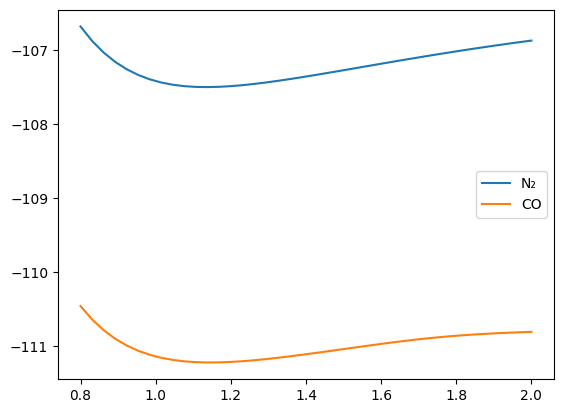

In [17]:
xs = np.linspace(0.8, 2, 40);
ys = [dimer_energy("N", "N", distance=y, basis="STO-3G") for y in xs];

# Ploting for N2
plt.plot(xs, ys, label="N₂");

# Regenerating ys for CO
ys = [dimer_energy("C", "O", distance=y, basis="STO-3G") for y in xs];

# Ploting for CO
plt.plot(xs, ys, label="CO");

plt.legend();

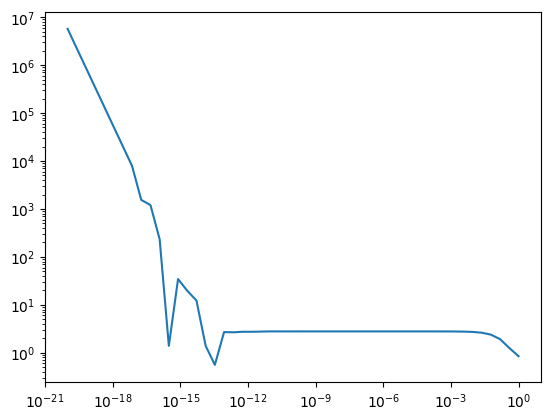

In [26]:
# TASK 2
def get_derivative(delta, center, x0):
  tmp = dimer_energy("N", "N", distance=(x0 + delta), basis="STO-3G");
  return ((tmp - center) / delta);


REFVALUE = 1.3979936186235125;
x0 = 1;

center = dimer_energy("N", "N", x0, "STO-3G");

deltas = 10**np.linspace(-20, 0);
derivatives = [get_derivative(delta, center, x0) for delta in deltas];

plt.loglog(deltas,
           np.abs(np.array(derivatives) - REFVALUE));


In [27]:
# TASK 3

# This code was given
def dimer_energy(element1, element2, distance, alchemical_change, basis):
    mol = pyscf.gto.M(atom=f"{element1} 0 0 0; {element2} 0 0 {distance}", basis=basis, verbose=0)
    calc = pyscf.scf.RHF(mol)
    h1 = calc.get_hcore()

    s = 0
    for i, delta_Z in enumerate([1, -1]):
        mol.set_rinv_orig_(mol.atom_coords()[i])
        s -= delta_Z * alchemical_change * mol.intor("int1e_rinv")

    nn = (alchemical_change * np.diff(mol.atom_charges())[0] - alchemical_change**2)
    nn /= (distance / pyscf.data.nist.BOHR)

    calc.get_hcore = lambda *args, **kwargs: h1 + s
    return calc.kernel() + nn

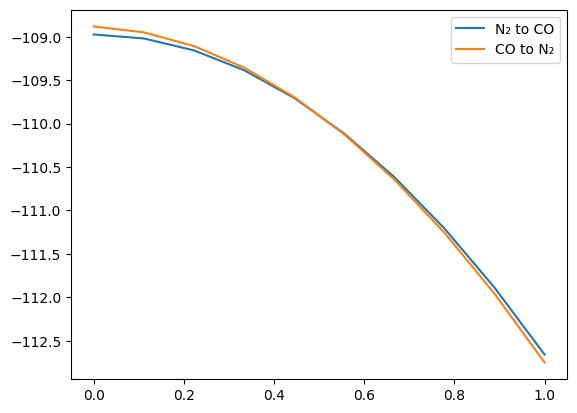

In [31]:
'''
N N      1      O C
N N     -1      C O
C O      1      N N
C O     -1      B F
'''

xs = np.linspace(0, 1, 10);
basis = "def2-TZVP";

N2_to_CO = [dimer_energy("N", "N", 1, _, basis) for _ in xs];
CO_to_N2 = [dimer_energy("C", "O", 1, _, basis) for _ in xs];

plt.plot(xs, N2_to_CO, label="N₂ to CO");
plt.plot(xs, CO_to_N2[::-1], label="CO to N₂");
plt.legend();

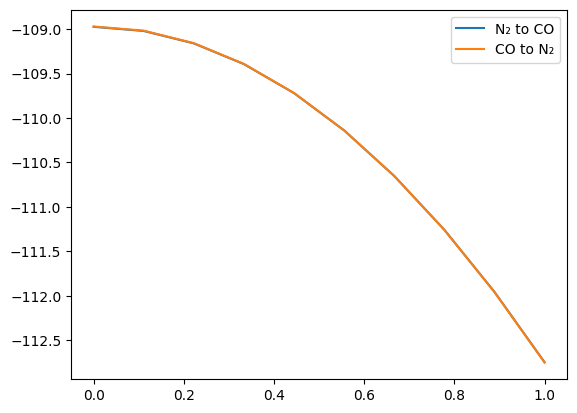

In [32]:
basis = "unc-def2-TZVP";

N2_to_CO = [dimer_energy("N", "N", 1, _, basis) for _ in xs];
CO_to_N2 = [dimer_energy("C", "O", 1, _, basis) for _ in xs];

plt.plot(xs, N2_to_CO, label="N₂ to CO");
plt.plot(xs, CO_to_N2[::-1], label="CO to N₂");
plt.legend();

# Class 4

In [43]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

In [44]:
# TASK 1

def LJ(r: float, sigma: float, epsilon: float) -> float:
  sr = sigma / r;
  v = 4*epsilon*((sr)**12 - (sr)**6);
  return v;

Text(0, 0.5, 'V(r)')

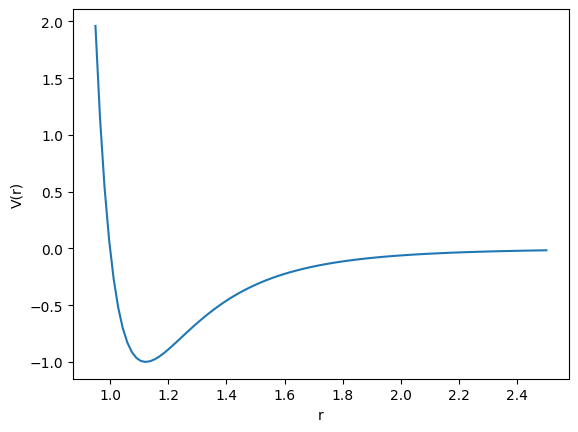

In [45]:
# TASK 2

epsilon = 1;
sigma = 1;

rs = np.linspace(0.95, 2.5, 100);
ys = LJ(r=rs, sigma=sigma, epsilon=epsilon);

plt.plot(rs, ys)
plt.xlabel("r")
plt.ylabel("V(r)")

In [46]:
# TASK 3

# Numerical derivative
def n_LJ_derivative(r: float, sigma: float, epsilon: float, delta=1e-5):
  return LJ((r + delta), sigma, epsilon) - LJ(r, sigma, epsilon) / delta;

Text(0, 0.5, "V'(r)")

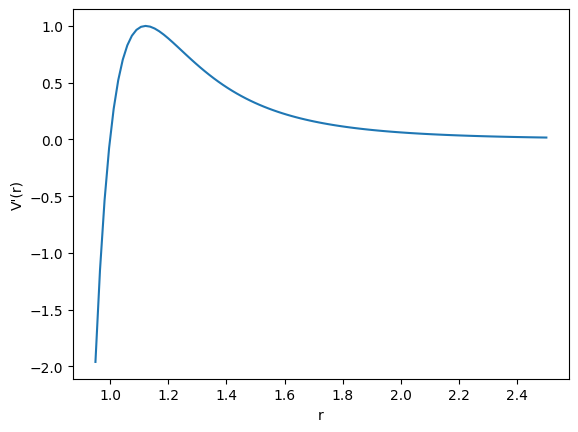

In [47]:
epsilon = 1e-5;

ys = n_LJ_derivative(r=rs, sigma=sigma, epsilon=epsilon);

plt.plot(rs, ys)
plt.xlabel("r")
plt.ylabel("V'(r)")

In [52]:
# TASK 4

# Analytical derivative
def a_LJ_derivative(r: float, sigma: float, epsilon: float):
  return (4*epsilon*(-12*sigma**12 + 6*(sigma**6)*r**6)/r**13);

Text(0, 0.5, "V'(r)")

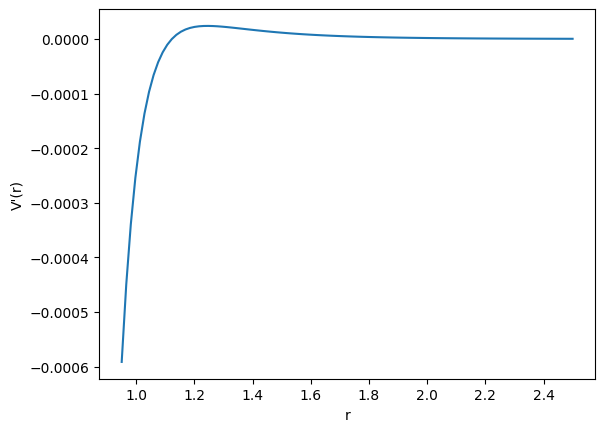

In [53]:
ys = a_LJ_derivative(r=rs, sigma=sigma, epsilon=epsilon);

plt.plot(rs, ys)
plt.xlabel("r")
plt.ylabel("V'(r)")

Text(0, 0.5, "V'(r)")

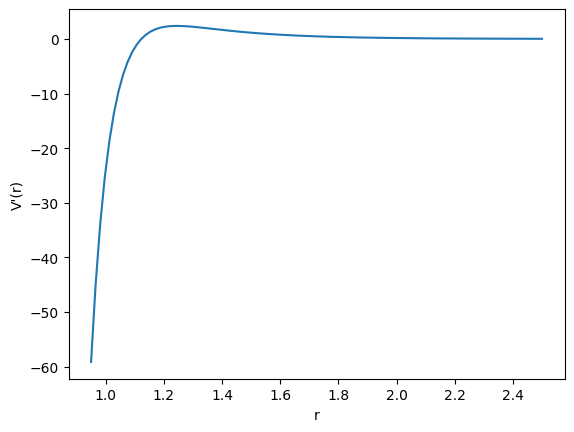

In [65]:
# TASK 5 and 6

dLJ = jax.grad(LJ);

# First solution (it's not good because it uses a loop)
# Jax doesn't allow to pass integers, you must pass floats
ys = [float(dLJ(r, 1., 1.)) for r in rs];

# Notice that this doesn't work
# ys = dLJ(rs);

# Second solution (better)
# using mapping: jax.vmap

plt.plot(rs, ys)
plt.xlabel("r")
plt.ylabel("V'(r)")

In [66]:
# Testing use of jax

jax.value_and_grad(LJ, [0, 1, 2])(1., 1., 1.)

(Array(0., dtype=float64, weak_type=True),
 (Array(-24., dtype=float64, weak_type=True),
  Array(24., dtype=float64, weak_type=True),
  Array(0., dtype=float64, weak_type=True)))

In [67]:
# TASK 7

import sympy as sp
def analytical_LJ_derivative(order: int):
    r, sigma, epsilon = sp.symbols("r \sigma \epsilon")
    return sp.diff(4*epsilon*((sigma/r)**12-(sigma/r)**6), r, order)

In [68]:
analytical_LJ_derivative(0)

4*\epsilon*(\sigma**12/r**12 - \sigma**6/r**6)

In [69]:
analytical_LJ_derivative(1)

4*\epsilon*(-12*\sigma**12/r**13 + 6*\sigma**6/r**7)

Some analyses on how jax works:

In [70]:
# Jax expression (jaxpression) for sin
jax.make_jaxpr(jnp.sin)(1.)

{ lambda ; a:f64[]. let b:f64[] = sin a in (b,) }

In [71]:
# sin' = cos
jax.make_jaxpr(jax.grad(jnp.sin))(1.)

{ lambda ; a:f64[]. let
    _:f64[] = sin a
    b:f64[] = cos a
    c:f64[] = mul 1.0 b
  in (c,) }

In [72]:
# sin'' = -sin
jax.make_jaxpr(jax.grad(
                        jax.grad(jnp.sin))
                        )(1.)

{ lambda ; a:f64[]. let
    _:f64[] = sin a
    _:f64[] = cos a
    b:f64[] = cos a
    c:f64[] = sin a
    _:f64[] = mul 1.0 b
    d:f64[] = mul 1.0 1.0
    e:f64[] = neg d
    f:f64[] = mul e c
  in (f,) }

In [73]:
# TASK 8

def energy(element1: str, element2: str, distance: float) -> float:
  if (distance > 10):
    return 0.0;

  table = {'Ar': (1.2, 3.), "Ne": (3., 2.7)}
  sigma1, epsilon1 = table[element1]
  sigma2, epsilon2 = table[element2]

  sigma = (sigma1 + sigma2) / 2;
  epsilon = jnp.sqrt(epsilon1 * epsilon2);

  # r s e
  return float(LJ(distance, sigma, epsilon));

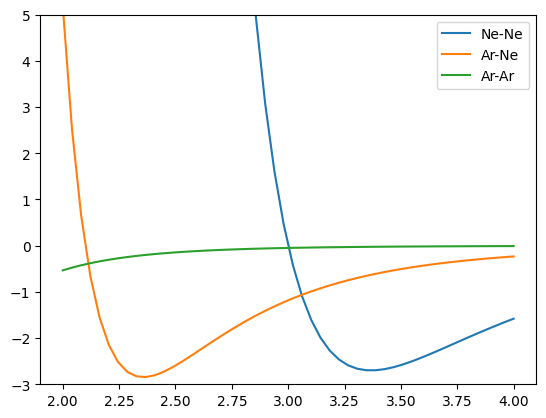

In [74]:
distances = np.linspace(2, 4);
Ne_Ne = [energy("Ne", "Ne", distance) for distance in distances];
Ar_Ne = [energy("Ar", "Ne", distance) for distance in distances];
Ar_Ar = [energy("Ar", "Ar", distance) for distance in distances];

plt.plot(distances, Ne_Ne, label="Ne-Ne");
plt.plot(distances, Ar_Ne, label="Ar-Ne");
plt.plot(distances, Ar_Ar, label="Ar-Ar");
plt.ylim(-3, 5);
plt.legend();

In [81]:
def LJ_many(elements: list[str], positions1d: np.array) -> float:
    table = {'Ar': (1.2, 3.), "Ne": (3., 2.7)}
    params = jnp.array([table[_] for _ in elements])
    epsilons = jnp.sqrt(jnp.outer(params[:, 1], params[:, 1]))
    sigmas = (params[:, 0, np.newaxis] + params[:, 0])/2

    rs = jnp.abs(positions1d[:, np.newaxis] - positions1d)
    rs = jnp.fill_diagonal(rs, 1e100, inplace=False)
    rmod = (sigmas/rs)**6
    all = 4*epsilons*(rmod**2-rmod)
    return jnp.triu(all, 1).sum()

LJ_many(["Ne", "Ne", "Ar"], jnp.array([0., 2., 4.]))

Array(1283.19678743, dtype=float64)